In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer
from qiskit_algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.circuit import ParameterVector

In [2]:
# Prepare graph data...
import os
from collections import namedtuple
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])
class GraphDataset():
    def __init__(self, input_dir, n_samples=None):
        input_dir = os.path.expandvars(input_dir)
        filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                     if f.startswith('event') and f.endswith('.npz')]
        self.filenames = (
            filenames[:n_samples] if n_samples is not None else filenames)

    def __getitem__(self, index):
        return load_graph(self.filenames[index])

    def __len__(self):
        return len(self.filenames)
def get_dataset(input_dir,n_files):
    return GraphDataset(input_dir, n_files)
def load_graph(filename):
    graph_dir = os.path.join(os.getcwd(), 'graphs')
    # Construct the full path to the specified file
    full_path = os.path.join(graph_dir, filename)
    """Read a single graph NPZ"""
    with np.load(full_path) as f:
        return sparse_to_graph(**dict(f.items()))
def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.float32):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)
#Function to load X, Ri, Ro, Y.
def load_raw(graph_name,xyr):
    graph_ex=load_graph(graph_name)
    #Load raw data
    y=graph_ex.y
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    X=graph_ex.X
    if xyr=='X':
        return X
    elif xyr=='Ri':
        return Ri
    elif xyr=='Ro':
        return Ro
    else:
        return y

In [4]:
# Load X data of dimension Nv x 4(including color)
import os
import pandas as pd
dir_ = os.path.join(os.getcwd(), 'color')
#dir_ = os.path.join(os.getcwd(), 'coloredX')
file_path = os.path.join(dir_, "event000001000_g000.csv")
v = pd.read_csv(file_path)
print("features data loaded...")

features data loaded...


In [5]:
#Convenient representation of edge data 
#edges = [[i1,j1], [i2,j2], ... ]; i1, i2,... are outgoing-nodes, and j1, j2, ... are incoming-nodes
import json
graph='event000001000_g000'
with open("./networks/"+graph+".json", "r") as json_file:
        _,_,edges= json.load(json_file)
print("edge data loaded...")

edge data loaded...


In [6]:
#Reduced adjacency matrix A
cut=5
#A[i][j]==1 implies there is an edge between i, j-th nodes.
A=[[0 for _ in range(cut)] for _ in range(cut)]
#Collect edges with its end in the "cut" bound
red_edges=[]
for s,e in edges:
    if s<cut and e<cut:
        red_edges.append([s,e])
for s,e in red_edges:
    A[s][e]=1
print("Adjacency matrix prepared...")

Adjacency matrix prepared...


In [7]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
# Reduced colored X data
raw_data=v[:cut].values
# Create a quantum circuit with Nv qubits
Nv = len(raw_data)
num_qubits = Nv * 4  # 4 qubits per row (x,y,z,color)
# Initialize a quantum circuit
import math
qc = QuantumCircuit(num_qubits)
feature = []
for i in range(num_qubits):
    feature.append(Parameter('phi_{}'.format(i)))
# Encode each feature value into a qubit 
for i in range(Nv):
    for j in range(4):
        qc.ry(feature[i*4+j], i * 4+j)
    #Entangle 3 positions
    qc.cx(i * 4, i * 4 + 1)
    qc.cx(i * 4 + 1, i * 4 + 2)
    qc.cx(i * 4 + 2, i * 4)
    #Entangle color and position-x.
    qc.cx(i * 4, i * 4 + 3)
# Encode each feature value into a qubit 
print("All 4 features encoded in QC...")

All 4 features encoded in QC...


In [8]:
# Define a list of trainable parameters for the entanglement
num_params = len(A)  # Number of trainable parameters for the entanglement
ansatz = []
for i in range(num_params):
    ansatz.append(Parameter('theta_{}'.format(i)))
print("Entangling qubits using fake adjacency matrix...")
# Apply trainable entanglement gates based on adjacency matrix A
for i in range(len(A)):
    qc.ry(ansatz[i],i*4)
for i in range(len(A)):
    for j in range(i + 1, len(A)):
        if A[i][j] == 1:
            # Use trainable parameters for entanglement angles
            qc.cx(i * 4, j * 4)
print("Parameterized quantum circuit ready...")

Entangling qubits using fake adjacency matrix...
Parameterized quantum circuit ready...


In [9]:
# Add measurement operations based on adjacency matrix A
look = [0 for _ in range(len(A))]
for i in range(len(A)):
    for j in range(i + 1, len(A)):
        if A[i][j] == 1:
            look[j]=1
#Edge info is collected in look
#Would like to compare it with QNN output
print("Compare Y with the following positions..")
print(look)

Compare Y with the following positions..
[0, 1, 1, 1, 1]


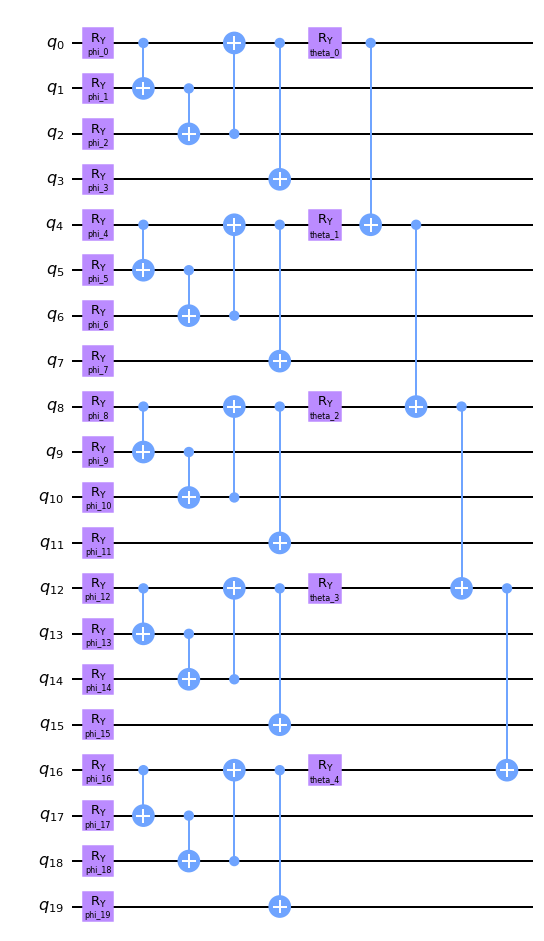

In [10]:
from qiskit import transpile
# Transpile the circuit for execution
simulator = Aer.get_backend('qasm_simulator')
full_circuit = transpile(qc, simulator)
# Visualize the transpiled circuit
full_circuit.draw(output='mpl')

In [11]:
#Implement quantum neural network
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
#Custom interpreter for our purpose:
#Create size Ne binary string
def custom_interpret(x):
    binary_str="{:b}".format(x)
    slice_length = len(binary_str) // Nv
    results = 0
    for i in range(Nv):
        s, e = i * slice_length, (i + 1) * slice_length
        #Chop up the binary string into Nv pieces
        slice_binary = binary_str[s:e]
        #Collect information for each piece
        parity = slice_binary.count("1") % 2
        #Form an integer using the bits
        results+=(parity*2**i)
    return results
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature,
    weight_params=ansatz,
    interpret = custom_interpret,
    #Output shape is 2^(number of qubits)
    output_shape = 2**Nv
)

In [12]:
# Callback function to plot the loss
from IPython.display import clear_output
#Set the same label for all 4 qubits in a single node
def expand_y(y):
    n=len(y)
    Y=[0 for _ in range(4*n)]
    for i in range(n):
        for j in range(4):
            Y[4*i+j]=y[i]
    return np.array(Y)
objective_func_vals = []
#Loss graph to track the training
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
def simple_callback(weights,obj_func_eval):
    print("training...","current loss is...",obj_func_eval)
# Create a neural network classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,optimizer=COBYLA(maxiter=20),
    loss='cross_entropy',callback=simple_callback)
# Prepare data for training (quantum circuits and labels)
y = load_raw('event000001000_g000.npz','y')
# For now, only look at first "cut" edges.
Y = y[:cut]  # True edge labels of dimension
Y = expand_y(Y)
flat_raw_data=raw_data.flatten()
# Train the classifier using the encoded quantum circuits and labels
sampler_classifier.fit(flat_raw_data, Y)
print("Fitted!")

training... current loss is... [-0.41925983]
training... current loss is... [-0.51298909]
training... current loss is... [-0.52101599]
training... current loss is... [-0.57668663]
training... current loss is... [-0.54959129]
training... current loss is... [-0.51801783]
training... current loss is... [-0.64564221]
training... current loss is... [-0.6669725]
training... current loss is... [-0.68198223]
training... current loss is... [-0.65761273]
training... current loss is... [-0.65992216]
training... current loss is... [-0.66338826]
training... current loss is... [-0.65690493]
training... current loss is... [-0.689472]
training... current loss is... [-0.69097205]
training... current loss is... [-0.68969339]
training... current loss is... [-0.69006763]
training... current loss is... [-0.69285292]
training... current loss is... [-0.69230837]
training... current loss is... [-0.69359631]
Fitted!


In [19]:
# It's supposed to produce something like 
# look='10101'
def intTobit(arr):
    n=arr[0]
    st=''
    while n>0:
        n,q=divmod(n,2)
        st+=str(q)
    if len(st)<Nv:
        st+='0'
    print(st[::-1])
intTobit(sampler_classifier.predict(flat_raw_data))

01101


In [20]:
look

[0, 1, 1, 1, 1]

In [22]:
y[:5]

array([1., 0., 0., 0., 0.], dtype=float32)